In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from baseline import print_rules
from tasks.running_example import make_task

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# General Explanations

In [4]:
is_pred_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
mclass_tree = DecisionTreeClassifier()
mclass_tree.fit(X, mclass_diff)
class_names = comparer.class_names[mclass_tree.classes_]

In [6]:
feature_importances = mclass_tree.feature_importances_
feature_order = np.flip(np.argsort(feature_importances))

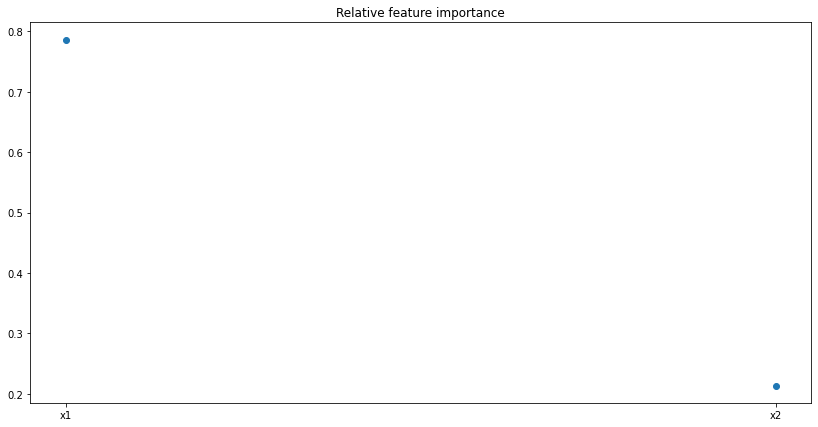

In [7]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Relative feature importance')
ax.scatter(comparer.feature_names[feature_order], feature_importances[feature_order])
plt.show()

In [8]:
class_names

array(['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'], dtype='<U6')

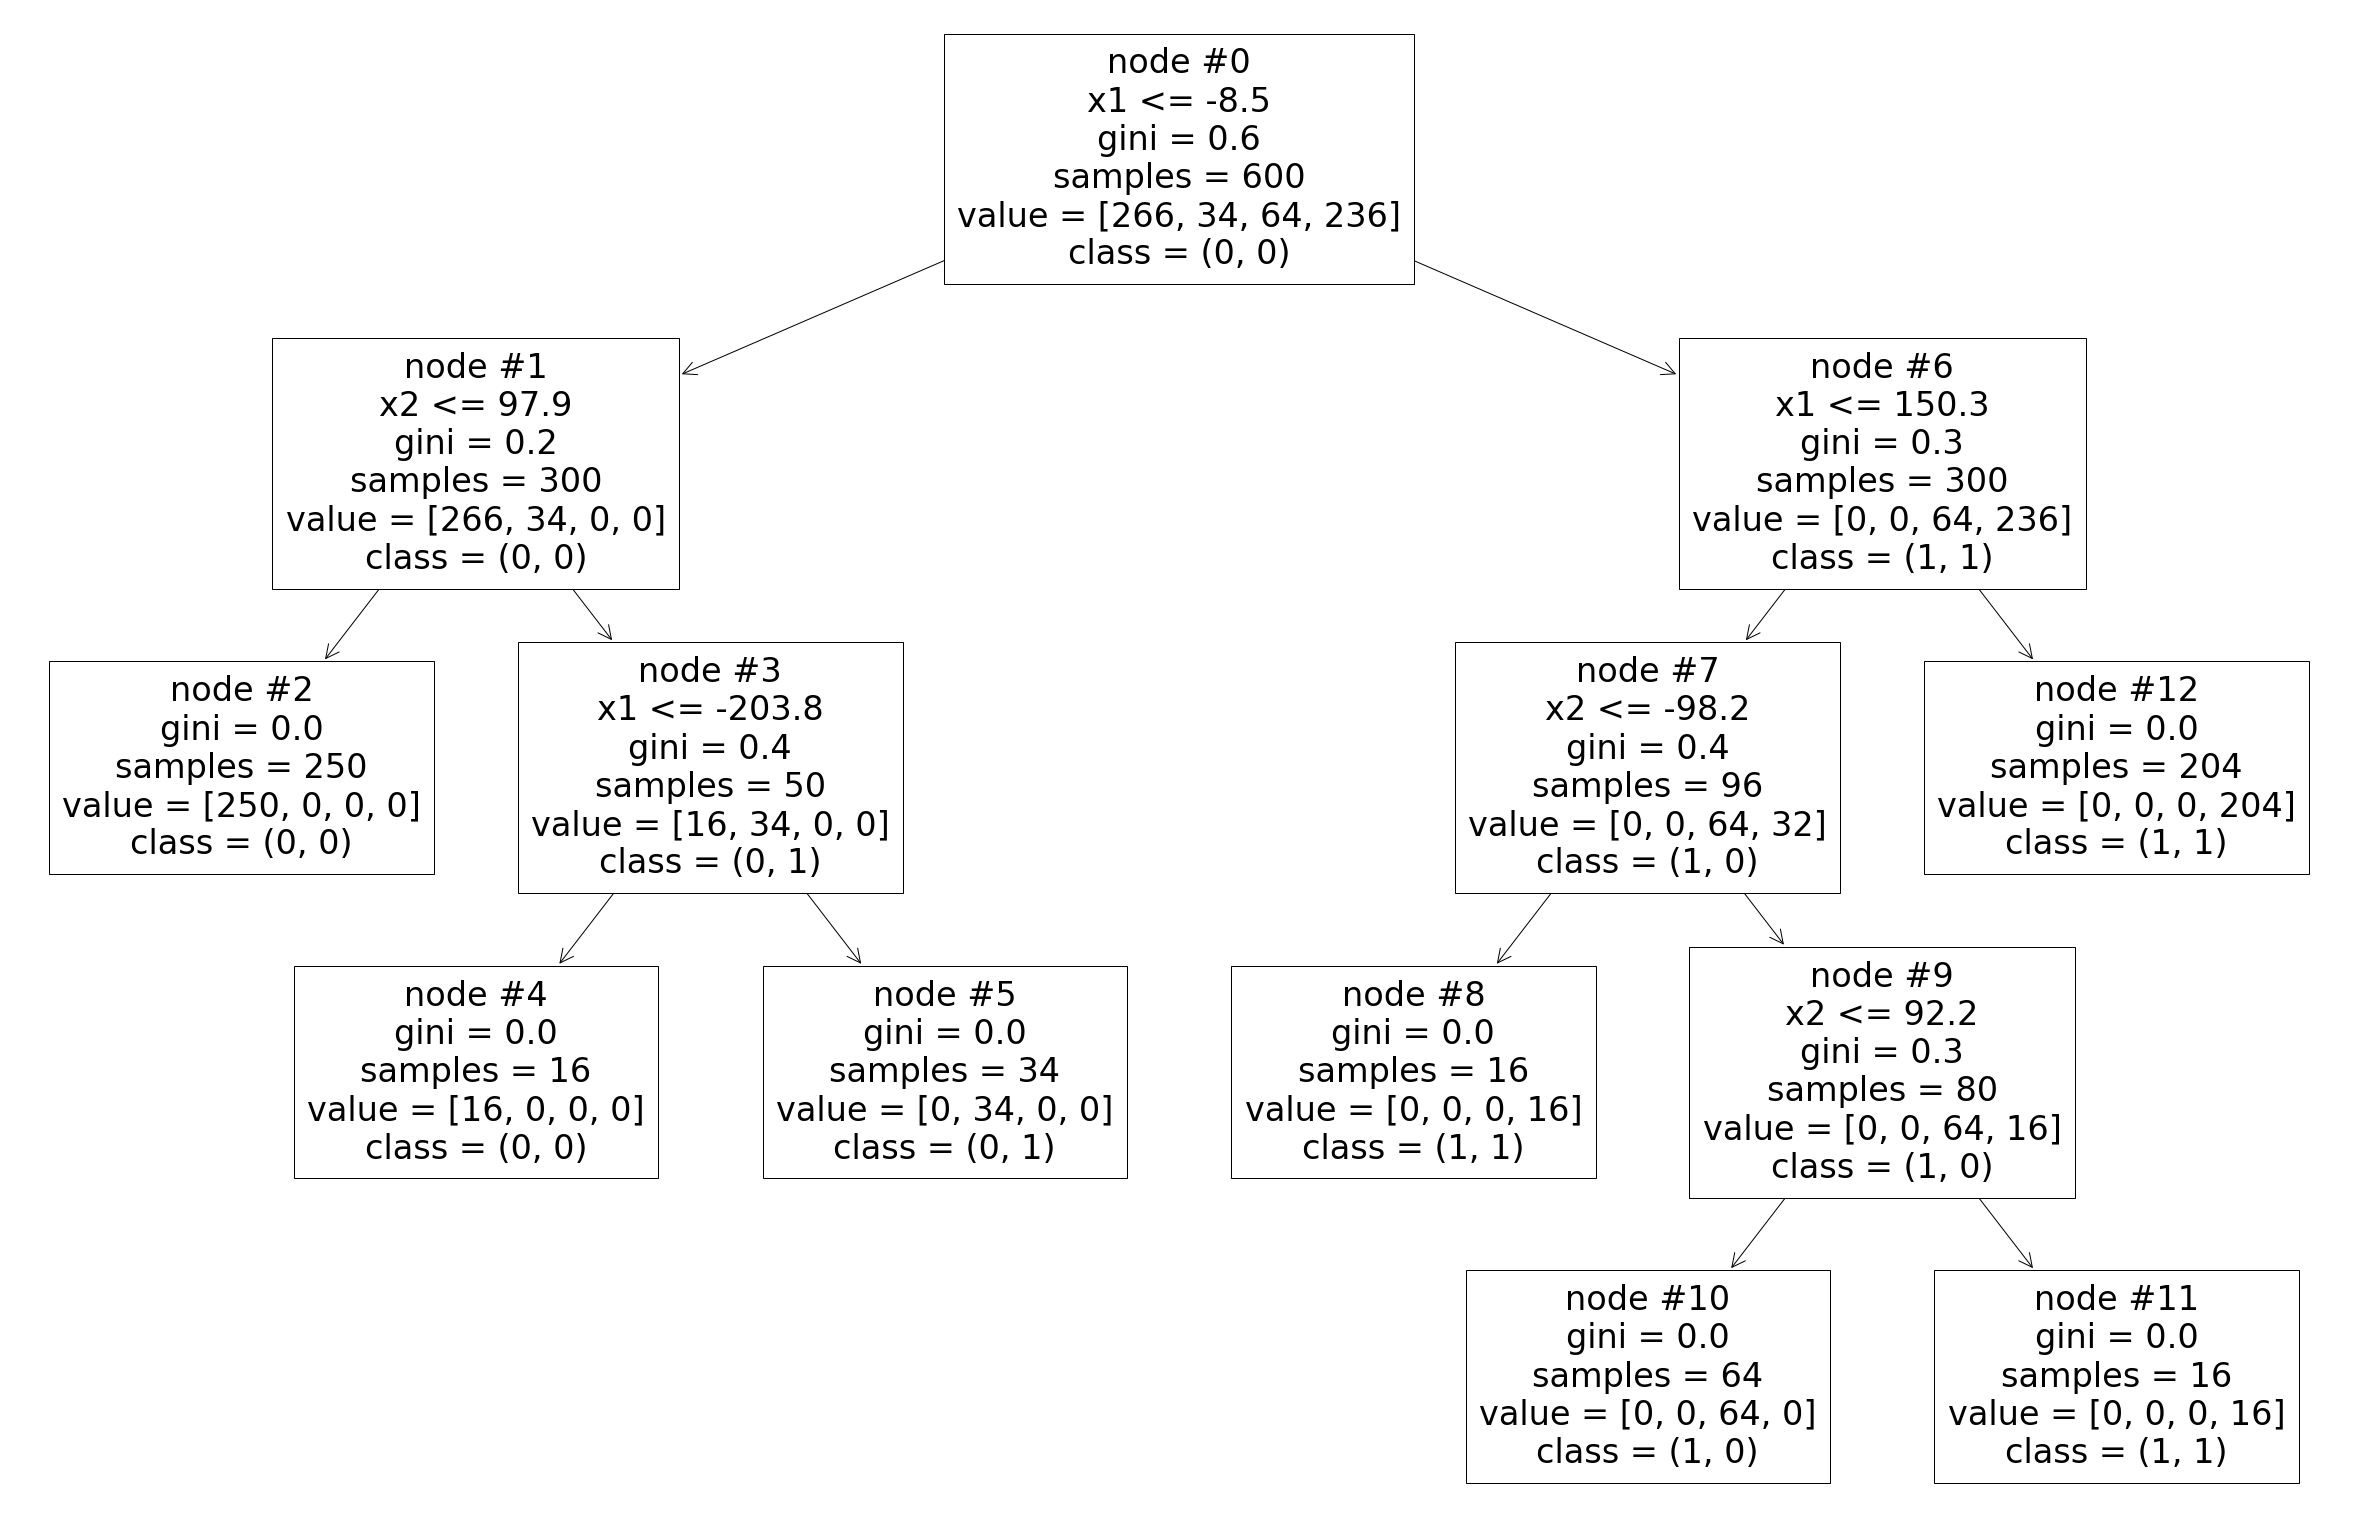

In [9]:
fig, ax = plt.subplots(figsize=(42, 28))
plot_tree(mclass_tree, feature_names=comparer.feature_names, class_names=class_names, ax=ax, precision=1, node_ids=True);

In [12]:
print_rules(mclass_tree, feature_names, class_names, '(0, 1)', feature_order)

node #5: if (x1 > -204.0) and (x1 <= -9.0) and (x2 > 97.0) then class (0, 1) (covers 1.0 of 34 instances)
coverage (train set): 1.0


In [13]:
print_rules(mclass_tree, feature_names, class_names, '(1, 0)', feature_order)

node #10: if (x1 > -9.0) and (x1 <= 150.0) and (x2 > -99.0) and (x2 <= 92.0) then class (1, 0) (covers 1.0 of 64 instances)
coverage (train set): 1.0


predictability: the explanation only generalizes to differences #1 and #2.


fidelity:
- of difference #1: no error
- of difference #2: x2 lower boundary differs by 10, the upper boundary by 5

selectiveness: best possible (minimal set of rules to describe the differences detected)

persuability: It can be argued, that not detecting difference #3 is no issue, since it is not within the data set and there might not exist any possible instances in this area. But the reported boundaries for difference #2 are quite different from the real boundaries, which could be an obstacle.